1. 引入必要的Python库

In [1]:
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertModel
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from model.BERT_RESNET import bertResModel
from model.BERT_ALEX import bertAlexModel
from model.BERT_VGG import bertVGGModel
from model.text import textModel
from model.image import imageModel

2. 调用GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


3. 观测数据集形态

In [3]:
for idx in range(1, 1001):
    with open('./data/' + str(idx) + '.txt', encoding='gb18030') as fp:
        text = fp.read()
        print(text)

How I feel today #legday #jelly #aching #gym 

grattis min griskulting!!!???? va bara tvungen oki s? sch ? @ingenkommeratttrodig #pig #happybday #wow #lovely #cut… 

RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE 

#escort We have a young and energetic team and we pride ourselves on offering the highes #hoer 

RT @chrisashaffer: Went to SSC today to be a "movie star" to rep for the Deaf and got to meet an energetic great guy: Mark White! 

RT @babeshawnmendes: "that was really energetic" 

RT @deepikapadukone: To my most hard working,fun loving and energetic team...Thank you and I love you! 

Energetic training today with our San Antonio New Dollars/New Partners trainees 

Look at their Photo and feel the #Anger. #SpeakUp for #peace. Speak up for #equality. Speak up for #Tolerance. 

@ArrivaTW absolute disgrace two carriages from Bangor half way there standing room only #disgraced 

RT @Dthompsonsmile: So proud of these kids! Not only talented, ENERGETIC a

4. 将文本转为Word Embedding

In [4]:
def word_embed(txt, token):
    result = token.batch_encode_plus(batch_text_or_text_pairs=txt, 
                                     truncation=True, 
                                     padding='max_length', 
                                     max_length=32, 
                                     return_tensors='pt')
    input_ids = result['input_ids']
    attention_mask = result['attention_mask']
    return input_ids, attention_mask

5. 统一数据格式

In [5]:
class NewDataset():
    def __init__(self, images, descriptions, tags, token):
        self.images = images
        self.descriptions = descriptions
        self.tags = tags
        self.input_ids, self.attention_masks = word_embed(self.descriptions, token)

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        img = self.images[idx]
        des = self.descriptions[idx]
        tag = self.tags[idx]
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        return img, des, tag, input_id, attention_mask

6. 编写训练过程并绘图

In [6]:
# 训练的过程
def train_model(model, epoch_num, optimizer, train_dataloader, valid_dataloader, train_count, valid_count):
    # 交叉熵损失函数
    loss_c = nn.CrossEntropyLoss()
    # 训练与验证的准确率
    train_acc = []
    valid_acc = []
    for epoch in range(epoch_num):
        loss = 0.0
        # 训练集和验证集正确判读的个数
        train_cor_count = 0
        valid_cor_count = 0
        for b_idx, (img, des, target, idx, mask) in enumerate(train_dataloader):
            img, mask, idx, target = img.to(device), mask.to(device), idx.to(device), target.to(device)
            output = model(idx, mask, img)
            optimizer.zero_grad()
            loss = loss_c(output, target)
            # 反向传播
            loss.backward()
            optimizer.step()
            pred = output.argmax(dim=1)
            train_cor_count += int(pred.eq(target).sum())
        # 训练集准确率
        train_acc.append(train_cor_count / train_count)
        for img, des, target, idx, mask in valid_dataloader:
            img, mask, idx, target = img.to(device), mask.to(device), idx.to(device), target.to(device)
            output = model(idx, mask, img)
            pred = output.argmax(dim=1)
            valid_cor_count += int(pred.eq(target).sum())
        # 验证集准确率
        valid_acc.append(valid_cor_count / valid_count)
        print('Train Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Accuracy: {:.4f}'.format(epoch+1,
                                                                                                           loss.item(),
                                                                                                           train_cor_count / train_count,
                                                                                                           valid_cor_count / valid_count))
            # 绘制准确率的图像
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(valid_acc, label="Valid Accuracy")
    plt.title("Bert ResNet")
    plt.xlabel("Epoch")
    plt.xticks(range(epoch_num), range(1, epoch_num+1))
    plt.ylabel("Accuracy")
    plt.ylim(ymin=0, ymax=1)
    plt.legend()
    plt.savefig('BERT_RESNET.png')
    plt.show()

7. 执行主函数

In [7]:
def main():
    model = bertResModel().to(device)
    lr = 1e-5
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_num = 10
    
    # 整体准备
    images = []
    descriptions = []
    tags = []
    emo_tag = {"neutral": 0, "negative": 1, "positive": 2}
    token = BertTokenizer.from_pretrained('bert-base-uncased')

    # 读取数据
    train_dataframe = pd.read_csv("./train.txt")
    for i in range(train_dataframe.shape[0]):
        guid = train_dataframe.iloc[i]['guid']
        tag = train_dataframe.iloc[i]['tag']
        img_path = f'./data/{guid}.jpg'
        img = Image.open(img_path).resize((224, 224), Image.Resampling.LANCZOS)
        img = np.asarray(img, dtype='float32')
        txt_path = f'./data/{guid}.txt'
        with open(txt_path, encoding='gb18030') as f:
            des = f.read()
        images.append(img.transpose(2, 0, 1))
        descriptions.append(des)
        tags.append(emo_tag[tag])
    
    # 收录词语
    for i in range(len(descriptions)):
        des = descriptions[i]
        # 空格分词，且去除Hashtag
        word_list = des.replace('#', '').split(' ')
        words_result = []
        for word in word_list:
            # 不是词
            if len(word) < 1:
                continue
            # 是网址或者用户名
            elif 'http' in word or word[0]=='@':
                continue
            else:
                words_result.append(word)
        descriptions[i] = ' '.join(words_result)
    
    # 图片与描述一一对应收录
    img_txt_pairs = [(images[i], descriptions[i]) for i in range(len(descriptions))]

    # 划分训练集与验证集
    X_train, X_valid, y_train, y_valid = train_test_split(img_txt_pairs, tags, test_size=0.2, random_state=42, shuffle=True)
    image_train, text_train = [X_train[i][0] for i in range(len(X_train))], [X_train[i][1] for i in range(len(X_train))]
    image_valid, text_valid = [X_valid[i][0] for i in range(len(X_valid))], [X_valid[i][1] for i in range(len(X_valid))]

    train_dataset = NewDataset(image_train, text_train, y_train, token)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_dataset = NewDataset(image_valid, text_valid, y_valid, token)
    valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

    # 模型训练
    train_model(model, epoch_num, optimizer, train_dataloader, valid_dataloader, len(X_train), len(X_valid))

    # 预测集进行预测
    emo_list = ['neutral', 'negative', 'positive']
    test_df = pd.read_csv('./test_without_label.txt')
    guid_list = test_df['guid'].tolist()
    tag_pre = []
    for idx in guid_list:
        img = Image.open('./data/' + str(idx) + '.jpg')
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        image = np.asarray(img, dtype='float32')
        image = image.transpose(2,0,1)
        with open('./data/' + str(idx) + '.txt', encoding='gb18030') as fp:
            description = fp.read()
        input_id, mask = word_embed([description], token)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        y_pred = model(input_id.to(device), mask.to(device), torch.Tensor(image).to(device))
        tag_pre.append(emo_list[y_pred[0].argmax(dim=-1).item()])
    
    result_df = pd.DataFrame({'guid':guid_list, 'tag':tag_pre})
    result_df.to_csv('./bert_resnet.txt',sep=',',index=False)

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1, Train Loss: 0.5446, Train Accuracy: 0.6216, Valid Accuracy: 0.7050
Train Epoch: 2, Train Loss: 0.6350, Train Accuracy: 0.8125, Valid Accuracy: 0.7037
Train Epoch: 3, Train Loss: 0.2117, Train Accuracy: 0.9478, Valid Accuracy: 0.7350
Train Epoch: 4, Train Loss: 0.0189, Train Accuracy: 0.9781, Valid Accuracy: 0.7125
Train Epoch: 5, Train Loss: 0.0121, Train Accuracy: 0.9866, Valid Accuracy: 0.7300
Train Epoch: 6, Train Loss: 0.0555, Train Accuracy: 0.9912, Valid Accuracy: 0.7350
Train Epoch: 7, Train Loss: 0.0444, Train Accuracy: 0.9900, Valid Accuracy: 0.7300
Train Epoch: 8, Train Loss: 0.0060, Train Accuracy: 0.9928, Valid Accuracy: 0.7113
Train Epoch: 9, Train Loss: 0.0011, Train Accuracy: 0.9934, Valid Accuracy: 0.7188
Train Epoch: 10, Train Loss: 0.0006, Train Accuracy: 0.9928, Valid Accuracy: 0.7238


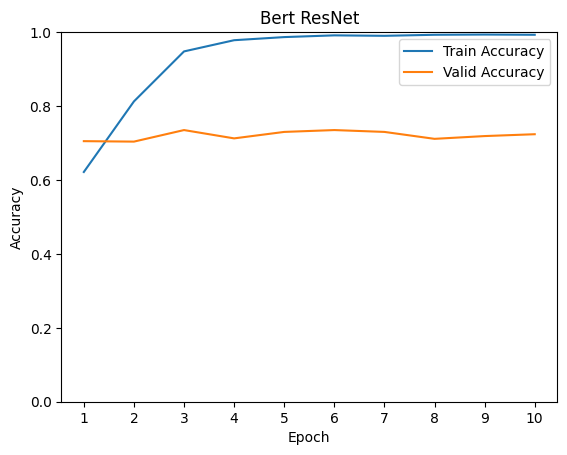

In [8]:
if __name__ == '__main__':
    main()